In [13]:
# %%
# for gridsearch

#!pip install pyyaml==5.4.1

# %%
from IPython import get_ipython  # type: ignore

# %% 
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')


# %%

from dotmap import DotMap
import json
import os

import numpy as np

# Import the PyTorch modules
import torch  # type: ignore
from torch import nn  # type: ignore
from torch.optim import SGD, Adam, RMSprop  # type: ignore

# Import Tensorflow writer
from torch.utils.tensorboard import SummaryWriter  # type: ignore

# Import modules from XTransformers
from x_transformers.x_transformers import AttentionLayers, Encoder, ContinuousTransformerWrapper


# Import the giotto-deep modules
from gdeep.data import OrbitsGenerator, DataLoaderKwargs
#from gdeep.topology_layers import AttentionPooling
from gdeep.topology_layers import ISAB, PMA, SAB
from gdeep.pipeline import Pipeline
from gdeep.search import Gridsearch
import json
#from gdeep.search import Gridsearch

from optuna.pruners import MedianPruner, NopPruner

# %%

#Configs
config_data = DotMap({
    'batch_size_train': 12,
    'num_orbits_per_class': 1_000,
    'validation_percentage': 0.0,
    'test_percentage': 0.0,
    'num_jobs': 2,
    'dynamical_system': 'classical_convention',
    'homology_dimensions': (0, 1),
    'dtype': 'float32',
    'arbitrary_precision': False
})


config_model = DotMap({
    'implementation': 'Old_SetTransformer', # SetTransformer, PersFormer,
    # PytorchTransformer, DeepSet, X-Transformer
    'dim_input': 4,
    'num_outputs': 1,  # for classification tasks this should be 1
    'num_classes': 5,  # number of classes
    'dim_hidden': 128,
    'num_heads': 8,
    'num_induced_points': 32,
    'layer_norm': False,  # use layer norm
    'pre_layer_norm': False,
    'num_layers_encoder': 4,
    'num_layers_decoder': 3,
    'attention_type': "induced_attention",
    'activation': nn.GELU,
    'dropout': 0.2,
    'optimizer': torch.optim.Adam,
    'learning_rate': 1e-3,
    'num_epochs': 1000,
    'pooling_type': "max",
    'weight_decay': 0.0,
    'n_accumulated_grads': 0,
})



# %%



# Define the data loader


dataloaders_dicts = DataLoaderKwargs(train_kwargs = {"batch_size":
                                                        config_data.batch_size_train,},
                                     val_kwargs = {"batch_size": 4},
                                     test_kwargs = {"batch_size": 3})

og = OrbitsGenerator(num_orbits_per_class=config_data.num_orbits_per_class,
                     homology_dimensions = config_data.homology_dimensions,
                     validation_percentage=config_data.validation_percentage,
                     test_percentage=config_data.test_percentage,
                     n_jobs=config_data.num_jobs,
                     dynamical_system = config_data.dynamical_system,
                     dtype=config_data.dtype,
                     arbitrary_precision=config_data.arbitrary_precision,
                     )

if config_data.arbitrary_precision:
    orbits = np.load(os.path.join('data', 'orbit5k_arbitrary_precision.npy'))
    og.orbits_from_array(orbits)

if config_data.dim_input == 2:
    dl_train, _, _ = og.get_dataloader_orbits(dataloaders_dicts)
else:
    dl_train, _, _ = og.get_dataloader_persistence_diagrams(dataloaders_dicts)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
class SetTransformer(nn.Module):
    """ Vanilla SetTransformer from
    https://github.com/juho-lee/set_transformer/blob/master/main_pointcloud.py
    """
    def __init__(
        self,
        dim_input=3,  # dimension of input data for each element in the set
        num_outputs=1,
        dim_output=40,  # number of classes
        num_inds=32,  # number of induced points, see  Set Transformer paper
        dim_hidden=128,
        num_heads=4,
        ln=False,  # use layer norm
    ):
        super(SetTransformer, self).__init__()
        self.enc = nn.Sequential(
            ISAB(dim_input, dim_hidden, num_heads, num_inds, ln=ln),
            ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln),
        )
        self.dec = nn.Sequential(
            nn.Dropout(),
            PMA(dim_hidden, num_heads, num_outputs, ln=ln),
            nn.Dropout(),
            nn.Linear(dim_hidden, dim_output),
        )

    def forward(self, input):
        return self.dec(self.enc(input)).squeeze()

In [15]:
model = torch.load("set_transformer_orbit5k__induced_attention_90_72%_acc.pth")
model.eval()

correct = 0
total = 0

dl = dl_train
use_cuda = True

for x_batch, y_batch in dl:
    if use_cuda:
        x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
    outputs = model(x_batch).squeeze(1)
    _, predictions = torch.max(outputs, 1)
    total += y_batch.size(0)
    correct += (predictions == y_batch).sum().item()

print("validation".capitalize(),
  'accuracy of the network on the', total,
  'diagrams: %8.2f %%' % (100 * correct / total)
  )

Validation accuracy of the network on the 5000 diagrams:    90.38 %


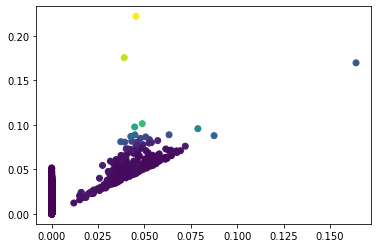

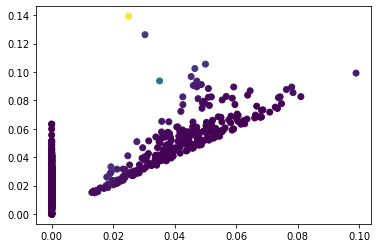

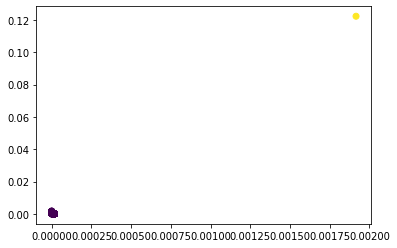

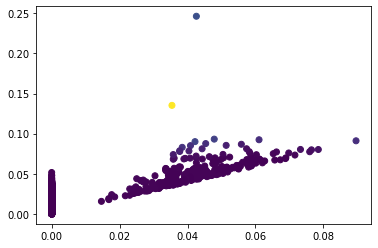

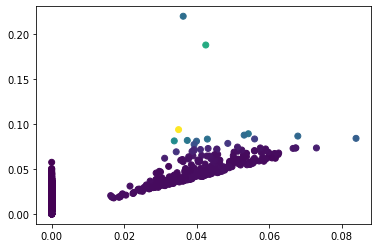

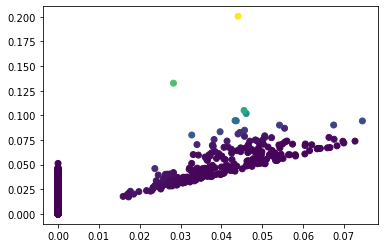

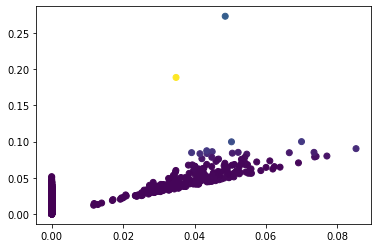

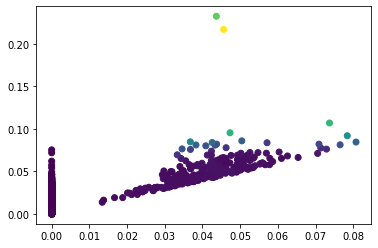

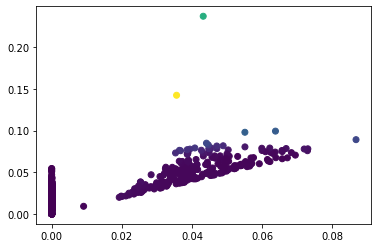

In [4]:
import matplotlib.pyplot as plt
class_ = 4
for i in list(range(1 + 1000 * class_, 10 + 1000 * class_)):
    x = torch.tensor(og.get_persistence_diagrams()[i, :, :])
    y = og._labels[i]
    delta = torch.zeros_like(x, requires_grad = True)
    loss = model((x + delta).unsqueeze(0).cuda())[int(y)]
    loss.backward()
    grads = torch.sqrt((delta.grad[:, :2]**2).sum(axis=-1))
    plt.scatter(x[:, 0], x[:, 1], c = grads)
    plt.show()

In [5]:
import plotly as px

tensor([0.1896, 0.1897, 0.1897,  ..., 1.5061, 1.5061, 1.5061])

In [ ]:
import plotly.express as px
import pandas as pd
class_ = 4
i = 4001
x = torch.tensor(og.get_persistence_diagrams()[i, :, :])
y = og._labels[i]
delta = torch.zeros_like(x, requires_grad = True)
loss = model((x + delta).unsqueeze(0).cuda())[int(y)]
loss.backward()
grads = torch.sqrt((delta.grad[:, :2]**2).sum(axis=-1))
plt.scatter(x[:, 0], x[:, 1], c = grads)
plt.show()
df = pd.dataframe(x[:, 2]
fig = px.scatter(df, x="sepal_width", y="sepal_length", color='petal_length')
fig.show()

In [18]:
import pandas as pd
import plotly.express as px

In [32]:
df = pd.DataFrame(np.concatenate((x.detach().numpy()[:, :2], grads.numpy().reshape(-1, 1)), -1))

In [33]:
df

,0,1,2
0,0.000000,0.000537,0.189587
1,0.000000,0.000862,0.189713
2,0.000000,0.000956,0.189750
3,0.000000,0.001217,0.189852
4,0.000000,0.002286,0.190272
...,...,...,...
1311,0.000016,0.000016,1.506130
1312,0.000016,0.000016,1.506130
1313,0.000016,0.000016,1.506130
1314,0.000016,0.000016,1.506130


In [28]:
grads.numpy().reshape(-1, 1).shape

(1316, 1)

In [30]:
(x.detach().numpy()[:, :2]).shape

(1316, 2)

In [34]:
fig = px.scatter(df, x=0, y=1, color=2)
fig.show()

In [36]:
grads.max()

tensor(212.1124)

In [37]:
model

SetTransformer(
  (enc): Sequential(
    (0): ISAB(
      (mab0): MAB(
        (fc_q): Linear(in_features=128, out_features=128, bias=True)
        (fc_k): Linear(in_features=4, out_features=128, bias=True)
        (fc_v): Linear(in_features=4, out_features=128, bias=True)
        (fc_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (mab1): MAB(
        (fc_q): Linear(in_features=4, out_features=128, bias=True)
        (fc_k): Linear(in_features=128, out_features=128, bias=True)
        (fc_v): Linear(in_features=128, out_features=128, bias=True)
        (fc_o): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (1): ISAB(
      (mab0): MAB(
        (fc_q): Linear(in_features=128, out_features=128, bias=True)
        (fc_k): Linear(in_features=128, out_features=128, bias=True)
        (fc_v): Linear(in_features=128, out_features=128, bias=True)
        (fc_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (mab1): MAB(
     